In [29]:
import os

import gym
import gym_nav
import numpy as np
import torch
from gym.spaces.box import Box
from gym.wrappers.clip_action import ClipAction
from stable_baselines3.common.atari_wrappers import (ClipRewardEnv,
                                                     EpisodicLifeEnv,
                                                     FireResetEnv,
                                                     MaxAndSkipEnv,
                                                     NoopResetEnv, WarpFrame)
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import (DummyVecEnv, SubprocVecEnv,
                                              VecEnvWrapper)
from stable_baselines3.common.vec_env.vec_normalize import \
    VecNormalize as VecNormalize_
from collections import deque

try:
    import dmc2gym
except ImportError:
    pass

try:
    import roboschool
except ImportError:
    pass

try:
    import pybullet_envs
except ImportError:
    pass


def make_env(env_id, seed, rank, log_dir, allow_early_resets, capture_video=False,
                env_kwargs=None):
    def _thunk():

        if env_id.startswith("dm"):
            _, domain, task = env_id.split('.')
            env = dmc2gym.make(domain_name=domain, task_name=task)
            env = ClipAction(env)
        else:
            if env_kwargs is not None:
                env = gym.make(env_id, **env_kwargs)
            else:
                env = gym.make(env_id)

        #Andy: add capture video wrapper
        if capture_video is not False and capture_video != 0 and rank == 0:
            # env = gym.wrappers.Monitor(env, './video', 
            #     video_callable=lambda t:t%capture_video==0, force=True)
            env = gym.wrappers.RecordVideo(env, './video',
                episode_trigger=lambda t:t%capture_video==0)

        is_atari = hasattr(gym.envs, 'atari') and isinstance(
            env.unwrapped, gym.envs.atari.atari_env.AtariEnv)
        if is_atari:
            env = NoopResetEnv(env, noop_max=30)
            env = MaxAndSkipEnv(env, skip=4)

        env.seed(seed + rank)

        if str(env.__class__.__name__).find('TimeLimit') >= 0:
            env = TimeLimitMask(env)

        if log_dir is not None:
            env = Monitor(env,
                          os.path.join(log_dir, str(rank)),
                          allow_early_resets=allow_early_resets)

        if is_atari:
            if len(env.observation_space.shape) == 3:
                env = EpisodicLifeEnv(env)
                if "FIRE" in env.unwrapped.get_action_meanings():
                    env = FireResetEnv(env)
                env = WarpFrame(env, width=84, height=84)
                env = ClipRewardEnv(env)
        elif len(env.observation_space.shape) == 3:
            raise NotImplementedError(
                "CNN models work only for atari,\n"
                "please use a custom wrapper for a custom pixel input env.\n"
                "See wrap_deepmind for an example.")

        # If the input has shape (W,H,3), wrap for PyTorch convolutions
        obs_shape = env.observation_space.shape
        if len(obs_shape) == 3 and obs_shape[2] in [1, 3]:
            env = TransposeImage(env, op=[2, 0, 1])

        return env

    return _thunk

#Andy: add capture video param, add optional env kwargs
def make_vec_envs(env_name,
                  num_processes=1,
                  seed=None,
                  gamma=0.99,
                  log_dir=None,
                  device=torch.device('cpu'),
                  allow_early_resets=True,
                  num_frame_stack=None,
                  capture_video=False,
                  normalize=True,
                  env_kwargs={},
                  auxiliary_tasks=[],
                  auxiliary_task_args=[]):
    if seed is None:
        seed = np.random.randint(0, 1e9)
        
    envs = [
        make_env(env_name, seed, i, log_dir, allow_early_resets, capture_video,
                env_kwargs)
        for i in range(num_processes)
    ]

    if len(envs) > 1:
        envs = SubprocVecEnv(envs)
    else:
        envs = DummyVecEnv(envs)

    if len(envs.observation_space.shape) == 1 and normalize:
        if gamma is None:
            envs = VecNormalize(envs, norm_reward=False)
        else:
            envs = VecNormalize(envs, gamma=gamma)

    # envs = VecPyTorch(envs, device)
    envs = AuxVecPyTorch(envs, device, auxiliary_tasks, auxiliary_task_args)

    if num_frame_stack is not None:
        envs = VecPyTorchFrameStack(envs, num_frame_stack, device)
    elif len(envs.observation_space.shape) == 3:
        envs = VecPyTorchFrameStack(envs, 4, device)

    return envs


# Checks whether done was caused my timit limits or not
class TimeLimitMask(gym.Wrapper):
    def step(self, action):
        obs, rew, done, info = self.env.step(action)
        if done and self.env._max_episode_steps == self.env._elapsed_steps:
            info['bad_transition'] = True

        return obs, rew, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)


# Can be used to test recurrent policies for Reacher-v2
class MaskGoal(gym.ObservationWrapper):
    def observation(self, observation):
        if self.env._elapsed_steps > 0:
            observation[-2:] = 0
        return observation


class TransposeObs(gym.ObservationWrapper):
    def __init__(self, env=None):
        """
        Transpose observation space (base class)
        """
        super(TransposeObs, self).__init__(env)


class TransposeImage(TransposeObs):
    def __init__(self, env=None, op=[2, 0, 1]):
        """
        Transpose observation space for images
        """
        super(TransposeImage, self).__init__(env)
        assert len(op) == 3, "Error: Operation, " + str(op) + ", must be dim3"
        self.op = op
        obs_shape = self.observation_space.shape
        self.observation_space = Box(
            self.observation_space.low[0, 0, 0],
            self.observation_space.high[0, 0, 0], [
                obs_shape[self.op[0]], obs_shape[self.op[1]],
                obs_shape[self.op[2]]
            ],
            dtype=self.observation_space.dtype)

    def observation(self, ob):
        return ob.transpose(self.op[0], self.op[1], self.op[2])


#Andy: Create a new Auxiliary Task env wrapper that can add auxiliary outputs
# through wrapper, so these are environment independent (although may require that
# some quantities are available in the environment). 
class AuxVecPyTorch(VecEnvWrapper):
    def __init__(self, venv, device, auxiliary_tasks=[], auxiliary_task_args=[]):
        """Return only every `skip`-th frame"""
        super(AuxVecPyTorch, self).__init__(venv)
        self.device = device
        
        available_auxiliary_tasks = {
            'terminal': 1
        }
        auxiliary_task_to_idx = {
            'terminal': 0
        }
        
        self.auxiliary_tasks = []
        self.auxiliary_task_args = auxiliary_task_args
        for task in auxiliary_tasks:
            if type(task) == int:
                self.auxiliary_tasks.append(task)
            elif task not in available_auxiliary_tasks.keys():
                raise NotImplementedError('Auxiliary task {} not found. Available options are '.format(
                    task, ', '.join(available_auxiliary_tasks.keys())))
            else:
                self.auxiliary_tasks.append(auxiliary_task_to_idx[task])

        self.episode_lengths = deque(maxlen=200)
        self.episode_lengths.append(200)

    def reset(self):
        obs = self.venv.reset()
        obs = torch.from_numpy(obs).float().to(self.device)
        return obs

    def step_async(self, actions):
        if isinstance(actions, torch.LongTensor):
            # Squeeze the dimension for discrete actions
            actions = actions.squeeze(1)
        actions = actions.cpu().numpy()
        self.venv.step_async(actions)

    def step_wait(self):
        obs, reward, done, info = self.venv.step_wait()
        obs = torch.from_numpy(obs).float().to(self.device)
        reward = torch.from_numpy(reward).unsqueeze(dim=1).float()
        
        
        for t, task in enumerate(self.auxiliary_tasks):
            #Note we assume that 'current_steps' is an attribute of the
            # environment. We could rewrite this so that the wrapper itself
            # keeps track of step counts so it becomes fully environment independent
            if task == 0:
                steps = self.venv.get_attr('current_steps')
                mean_steps = np.mean(self.episode_lengths)
                for n, i in enumerate(info):
                    if 'episode' in i.keys():
                        self.episode_lengths.append(i['episode']['l'])
                    if 'auxiliary' in i.keys():
                        i['auxiliary'] = np.append(i['auxiliary'], [steps[n]/mean_steps])
                    else:
                        i['auxiliary'] = np.array([steps[n]/mean_steps])
        
        
        return obs, reward, done, info


class VecPyTorch(VecEnvWrapper):
    def __init__(self, venv, device):
        """Return only every `skip`-th frame"""
        super(VecPyTorch, self).__init__(venv)
        self.device = device
        # TODO: Fix data types

    def reset(self):
        obs = self.venv.reset()
        obs = torch.from_numpy(obs).float().to(self.device)
        return obs

    def step_async(self, actions):
        if isinstance(actions, torch.LongTensor):
            # Squeeze the dimension for discrete actions
            actions = actions.squeeze(1)
        actions = actions.cpu().numpy()
        self.venv.step_async(actions)

    def step_wait(self):
        obs, reward, done, info = self.venv.step_wait()
        obs = torch.from_numpy(obs).float().to(self.device)
        reward = torch.from_numpy(reward).unsqueeze(dim=1).float()
        return obs, reward, done, info


class VecNormalize(VecNormalize_):
    def __init__(self, *args, **kwargs):
        super(VecNormalize, self).__init__(*args, **kwargs)
        self.training = True

    def _obfilt(self, obs, update=True):
        if self.obs_rms:
            if self.training and update:
                self.obs_rms.update(obs)
            obs = np.clip((obs - self.obs_rms.mean) /
                          np.sqrt(self.obs_rms.var + self.epsilon),
                          -self.clip_obs, self.clip_obs)
            return obs
        else:
            return obs

    def train(self):
        self.training = True

    def eval(self):
        self.training = False


# Derived from
# https://github.com/openai/baselines/blob/master/baselines/common/vec_env/vec_frame_stack.py
class VecPyTorchFrameStack(VecEnvWrapper):
    def __init__(self, venv, nstack, device=None):
        self.venv = venv
        self.nstack = nstack

        wos = venv.observation_space  # wrapped ob space
        self.shape_dim0 = wos.shape[0]

        low = np.repeat(wos.low, self.nstack, axis=0)
        high = np.repeat(wos.high, self.nstack, axis=0)

        if device is None:
            device = torch.device('cpu')
        self.stacked_obs = torch.zeros((venv.num_envs, ) +
                                       low.shape).to(device)

        observation_space = gym.spaces.Box(low=low,
                                           high=high,
                                           dtype=venv.observation_space.dtype)
        VecEnvWrapper.__init__(self, venv, observation_space=observation_space)

    def step_wait(self):
        obs, rews, news, infos = self.venv.step_wait()
        self.stacked_obs[:, :-self.shape_dim0] = \
            self.stacked_obs[:, self.shape_dim0:].clone()
        for (i, new) in enumerate(news):
            if new:
                self.stacked_obs[i] = 0
        self.stacked_obs[:, -self.shape_dim0:] = obs
        return self.stacked_obs, rews, news, infos

    def reset(self):
        obs = self.venv.reset()
        if torch.backends.cudnn.deterministic:
            self.stacked_obs = torch.zeros(self.stacked_obs.shape)
        else:
            self.stacked_obs.zero_()
        self.stacked_obs[:, -self.shape_dim0:] = obs
        return self.stacked_obs

    def close(self):
        self.venv.close()

        
def evaluate(actor_critic, obs_rms=None, normalize=True, env_name='NavEnv-v0', seed=None, num_processes=1,
             device=torch.device('cpu'), ret_info=1, capture_video=False, env_kwargs={}, data_callback=None,
             num_episodes=10, verbose=0, with_activations=False, deterministic=True,
             aux_wrapper_kwargs={}, auxiliary_truth_sizes=[],
             eval_log_dir=None):
    '''
    ret_info: level of info that should be tracked and returned
    capture_video: whether video should be captured for episodes
    env_kwargs: any kwargs to create environment with
    data_callback: a function that should be called at each step to pull information
        from the environment if needed. The function will take arguments
            def callback(actor_critic, vec_envs, recurrent_hidden_states, data):
        actor_critic: the actor_critic network
        vec_envs: the vec envs (can call for example vec_envs.get_attr('objects') to pull data)
        recurrent_hidden_states: these are given in all data, but may want to use in computation
        obs: observation this step (after taking action) - 
            note that initial observation is never seen by data_callback
            also note that this observation will have the mean normalized
            so may instead want to call vec_envs.get_method('get_observation')
        action: actions this step
        reward: reward this step
        data: a data dictionary that will continuously be passed to be updated each step
            it will start as an empty dicionary, so keys must be initialized
        see below at example_data_callback in this file for an example
    '''

    if seed is None:
        seed = np.random.randint(0, 1e9)

    envs = make_vec_envs(env_name, env_kwargs=env_kwargs)

    vec_norm = utils.get_vec_normalize(envs)
    if vec_norm is not None:
        vec_norm.eval()
        vec_norm.obs_rms = obs_rms

    eval_episode_rewards = []

    all_obs = []
    all_actions = []
    all_rewards = []
    all_rnn_hxs = []
    all_dones = []
    all_masks = []
    all_activations = []
    all_values = []
    all_actor_features = []
    all_auxiliary_preds = []
    all_auxiliary_truths = []
    data = {}
    
    ep_obs = []
    ep_actions = []
    ep_rewards = []
    ep_rnn_hxs = []
    ep_dones = []
    ep_values = []
    ep_masks = []
    ep_actor_features = []
    
    ep_auxiliary_preds = []
    ep_activations = []
    ep_auxiliary_truths = []
    

    obs = envs.reset()
    rnn_hxs = torch.zeros(
        num_processes, actor_critic.recurrent_hidden_state_size, device=device)
    masks = torch.zeros(num_processes, 1, device=device)

    for i in range(num_episodes):
        step = 0
        
        while True:
            ep_obs.append(obs)
            ep_rnn_hxs.append(rnn_hxs)
            if data_callback is not None and step == 0:
                data = data_callback(None, envs, rnn_hxs,
                    obs, [], [], [False], data, first=True)

        
        
            with torch.no_grad():
                outputs = actor_critic.act(obs, rnn_hxs, 
                                        masks, deterministic=deterministic,
                                        with_activations=with_activations)
                action = outputs['action']
                rnn_hxs = outputs['rnn_hxs']
            obs, reward, done, infos = envs.step(action)
            
            masks = torch.tensor(
                [[0.0] if done_ else [1.0] for done_ in done],
                dtype=torch.float32,
                device=device)
            
            ep_actions.append(action)
            ep_rewards.append(reward)
            ep_dones.append(done)
            ep_values.append(outputs['value'])
            ep_masks.append(masks)
            ep_actor_features.append(outputs['actor_features'])
            
            if 'auxiliary_preds' in outputs:
                ep_auxiliary_preds.append(outputs['auxiliary_preds'])
            
            if with_activations:
                ep_activations.append(outputs['activations'])

            if data_callback is not None:
                data = data_callback(None, envs, rnn_hxs,
                    obs, action, reward, done, data)
            else:
                data = {}
                
            auxiliary_truths = [[] for i in range(len(actor_critic.auxiliary_output_sizes))]
            for info in infos:
                if 'auxiliary' in info and len(info['auxiliary']) > 0:
                    for i, aux in enumerate(info['auxiliary']):
                        auxiliary_truths[i].append(aux)
            if len(auxiliary_truths) > 0:
                auxiliary_truths = [torch.tensor(np.vstack(aux)) for aux in auxiliary_truths]
            ep_auxiliary_truths.append(auxiliary_truths)
            
            
            # for info in infos:
            #     if 'episode' in info.keys():
            #         eval_episode_rewards.append(info['episode']['r'])
            #         #Andy: add verbosity option
            #         if verbose >= 2:
            #             print('ep ' + str(len(eval_episode_rewards)) + ' rew ' + \
            #                 str(info['episode']['r']))
            
            if done[0]:
                all_obs.append(np.vstack(ep_obs))
                all_actions.append(np.vstack(ep_actions))
                all_rewards.append(np.vstack(ep_rewards))
                all_rnn_hxs.append(np.vstack(ep_rnn_hxs))
                all_dones.append(np.vstack(ep_dones))
                all_masks.append(np.vstack(ep_masks))
                all_values.append(np.vstack(ep_values))
                all_actor_features.append(np.vstack(ep_actor_features))
                
                all_auxiliary_preds.append(ep_auxiliary_preds)
                all_activations.append(ep_activations)
                all_auxiliary_truths.append(ep_auxiliary_truths)

                if data_callback is not None:
                    data = data_callback(None, envs, rnn_hxs,
                        obs, action, reward, done, data, stack=True)
                          
                if verbose >= 2:
                    print(f'ep {i}, rew {np.sum(ep_rewards)}' )
                    
                ep_obs = []
                ep_actions = []
                ep_rewards = []
                ep_rnn_hxs = []
                ep_dones = []
                ep_values = []
                ep_masks = []
                ep_actor_features = []
                
                ep_auxiliary_preds = []
                ep_activations = []
                ep_auxiliary_truths = []
                
                break
  

    envs.close()
    if verbose >= 1:
        print(" Evaluation using {} episodes: mean reward {:.5f}\n".format(
            len(eval_episode_rewards), np.mean(eval_episode_rewards)))

    return {
        'obs': all_obs,
        'actions': all_actions,
        'rewards': all_rewards,
        'rnn_hxs': all_rnn_hxs,
        'dones': all_dones,
        'masks': all_masks,
        'envs': envs,
        'data': data,
        'activations': all_activations,
        'values': all_values,
        'actor_features': all_actor_features,
        'auxiliary_preds': all_auxiliary_preds,
        'auxiliary_truths': all_auxiliary_truths,
    }


def example_data_callback(actor_critic, vec_envs, recurrent_hidden_states, data):
    pass



def nav_data_callback(agent, env, rnn_hxs, obs, action, reward, done, data, stack=False,
                      first=False):
    '''
    Add navigation data pos and angle to data object
    If stack is True, this function will handle stacking the data properly
    '''    
    if 'pos' not in data:
        data['pos'] = []
    if 'angle' not in data:
        data['angle'] = []
    if 'ep_pos' not in data:
        data['ep_pos'] = []
    if 'ep_angle' not in data:
        data['ep_angle'] = []

    if stack:
        data['pos'].append(np.vstack(data['ep_pos']))
        data['angle'].append(np.vstack(data['ep_angle']))
        
        data['ep_pos'] = []
        data['ep_angle'] = []        
    elif not done[0]:
        pos = env.get_attr('character')[0].pos.copy()
        angle = env.get_attr('character')[0].angle
        data['ep_pos'].append(pos)
        data['ep_angle'].append(angle)
    
    return data



def explore_data_callback(agent, env, rnn_hxs, obs, action, reward, done, data, stack=False,
                      first=False):
    '''
    Add navigation data pos and angle and position of platform to data
    '''
    if 'pos' not in data:
        data['pos'] = []
    if 'angle' not in data:
        data['angle'] = []
    if 'goal' not in data:
        data['goal'] = []
    if 'ep_pos' not in data:
        data['ep_pos'] = []
    if 'ep_angle' not in data:
        data['ep_angle'] = []
    if 'ep_goal' not in data:
        data['ep_goal'] = []

    if first:
        data['ep_goal'].append(env.envs[0].boxes[-1].corner)

    if stack:
        data['pos'].append(np.vstack(data['ep_pos']))
        data['angle'].append(np.vstack(data['ep_angle']))
        data['goal'].append(data['ep_goal'])
        
        data['ep_pos'] = []
        data['ep_angle'] = []        
        data['ep_goal'] = []
    elif not done[0]:
        pos = env.get_attr('character')[0].pos.copy()
        angle = env.get_attr('character')[0].angle
        data['ep_pos'].append(pos)
        data['ep_angle'].append(angle)
    
    return data

In [50]:
import sys
sys.path.append('../')
import a2c_ppo_acktr
from a2c_ppo_acktr import utils

env_kwargs = {'num_objects': 0, 'rew_structure': 'goal',
              'task_structure': 3, 'wall_colors': 4, 'num_rays': 12, 'fov': 1,
              'character_reset_pos': 1,  'one_hot_obs': True}
model, obs_rms = torch.load('../trained_models/ppo/nav_4wallexplore_batch128onehot_t0.pt')

res = evaluate(model, obs_rms, env_kwargs=env_kwargs, num_episodes=10, data_callback=explore_data_callback,
              verbose=2, num_processes=1)

ep 0, rew tensor([[0.]])
ep 1, rew tensor([[0.]])
ep 2, rew tensor([[14.2124]])
ep 3, rew tensor([[2.4150]])
ep 4, rew tensor([[0.]])
ep 5, rew tensor([[0.]])
ep 6, rew tensor([[0.]])
ep 7, rew tensor([[3.0023]])
ep 8, rew tensor([[2.9615]])
ep 9, rew tensor([[0.]])
 Evaluation using 0 episodes: mean reward nan



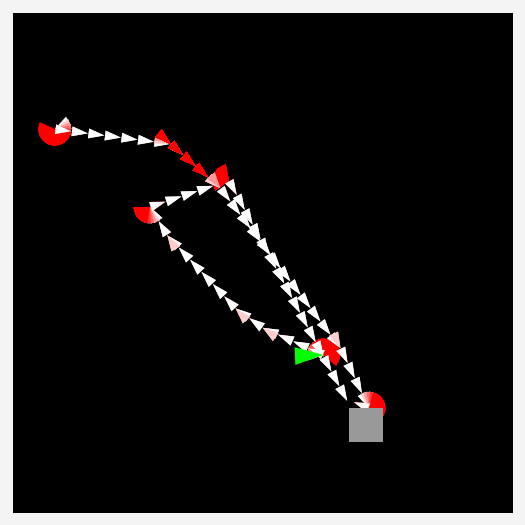

In [54]:
from trajectories import draw_trajectory
import proplot as pplt
import matplotlib.pyplot as plt

ep = 3

def draw_box(corner, size=[20, 20], ax=None, c=np.array([0.6, 0.6, 0.6])):
    rect = plt.Rectangle(corner, size[0], size[1], fc=np.array([0.6, 0.6, 0.6]))        
    if ax == None:
        plt.gca().add_patch(rect)
    else:
        ax.add_patch(rect)

fig, ax = pplt.subplots()

p = res['data']['pos'][ep]
a = res['data']['angle'][ep]
draw_trajectory(p, a, ax=ax)

corner = res['data']['goal'][ep][0]
draw_box(corner, ax=ax)



In [41]:
envs = make_vec_envs('NavEnv-v0', env_kwargs=env_kwargs)
envs.reset()
envs.envs[0].boxes[-1].size

[20, 20]